In [374]:
# %matplotlib inline
%config InlineBackend.figure_format = "retina"

In [375]:
import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [376]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid",
              palette="colorblind", color_codes=True,
              rc={"figure.figsize": [10, 5]})

In [377]:
import pandas as pd
import yfinance as yf
import datetime as dt
import numpy as np
import quantstats as qs
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(14,7)
import seaborn as sns
import plotly.express as px
plt.style.use('dark_background')
%matplotlib inline

In [378]:
ticker = ['NVDA']
start = '2022-08-01'
end = '2023-08-18'
prices_df = yf.download(ticker, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [379]:
prices_df

Open        High         Low       Close   Adj Close   
Date                                                                     
2022-08-01  181.820007  188.460007  179.899994  184.410004  184.257690  \
2022-08-02  181.220001  189.380005  180.919998  185.259995  185.106995   
2022-08-03  181.839996  189.679993  181.369995  188.929993  188.773972   
2022-08-04  188.490005  192.740005  187.600006  192.149994  191.991302   
2022-08-05  188.100006  192.289993  186.660004  189.889999  189.733170   
...                ...         ...         ...         ...         ...   
2023-08-11  417.510010  420.179993  406.390015  408.549988  408.549988   
2023-08-14  404.859985  438.000000  403.109985  437.529999  437.529999   
2023-08-15  445.600006  452.679993  437.100006  439.399994  439.399994   
2023-08-16  445.200012  446.750000  434.059998  434.859985  434.859985   
2023-08-17  439.700012  440.619995  430.010010  433.440002  433.440002   

              Volume  
Date                  
2022-08-01  47646900  
2022-08-02  48952700  
2022-08-03  41814600  
2022-08-04  40965200  
2022-08-05  38606800  
...              ...  
2023-08-11  53200900  
2023-08-14  69028600  
2023-08-15  67651200  
2023-08-16  52745100  
2023-08-17  45239500  

[264 rows x 6 columns]

In [380]:
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px
import pandas_bokeh
cf.go_offline()
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [381]:
prices_df['Adj Close'].iplot()

In [382]:
fig_price=px.line(prices_df['Adj Close'], title='NVDA')
fig_price.show()

In [383]:
adj_close= prices_df['Adj Close']

In [384]:
returns= prices_df['Adj Close'].pct_change().dropna()

In [385]:
returns

Date
2022-08-02    0.004609
2022-08-03    0.019810
2022-08-04    0.017043
2022-08-05   -0.011762
2022-08-08   -0.062984
                ...   
2023-08-11   -0.036166
2023-08-14    0.070934
2023-08-15    0.004274
2023-08-16   -0.010332
2023-08-17   -0.003265
Name: Adj Close, Length: 263, dtype: float64

In [386]:
returns.iplot()

In [387]:
returns.describe()

count    263.000000
mean       0.003883
std        0.035974
min       -0.094726
25%       -0.015708
50%        0.003011
75%        0.022537
max        0.243696
Name: Adj Close, dtype: float64

Split the data into training and test sets:

In [388]:
train = returns["2022"]
test = returns["2023"]

Specify the parameters of the simulation:

In [389]:
T = len(test)
N = len(test)
S_0 = prices_df.loc[train.index[-1], "Adj Close"]
N_SIM = 200
mu = train.mean()
sigma = train.std()

Define the function used for the simulations:

In [390]:
def simulate_gbm(S_0, mu, sigma, N_SIM, T, N):
    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt),
    size=(N_SIM, N))
    W = np.cumsum(dW, axis=1)
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (N_SIM, N))
    S_t = S_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps + sigma * W)
    S_t = np.insert(S_t, 0, S_0, axis=1)
    return S_t

Run the simulations and store the results in a DataFrame:

In [391]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)
sim_df = pd.DataFrame(np.transpose(gbm_simulations),
index=train.index[-1:].union(test.index))

Create a DataFrame with the average value for each time step and the corresponding actual stock price:

In [392]:
res_df = sim_df.mean(axis=1).to_frame()
res_df = res_df.join(prices_df["Adj Close"])
res_df.columns = ["simulation_average", "adj_close_price"]

Plot the results of the simulation:

<Axes: title={'center': "Simulation's results"}, xlabel='Date'>

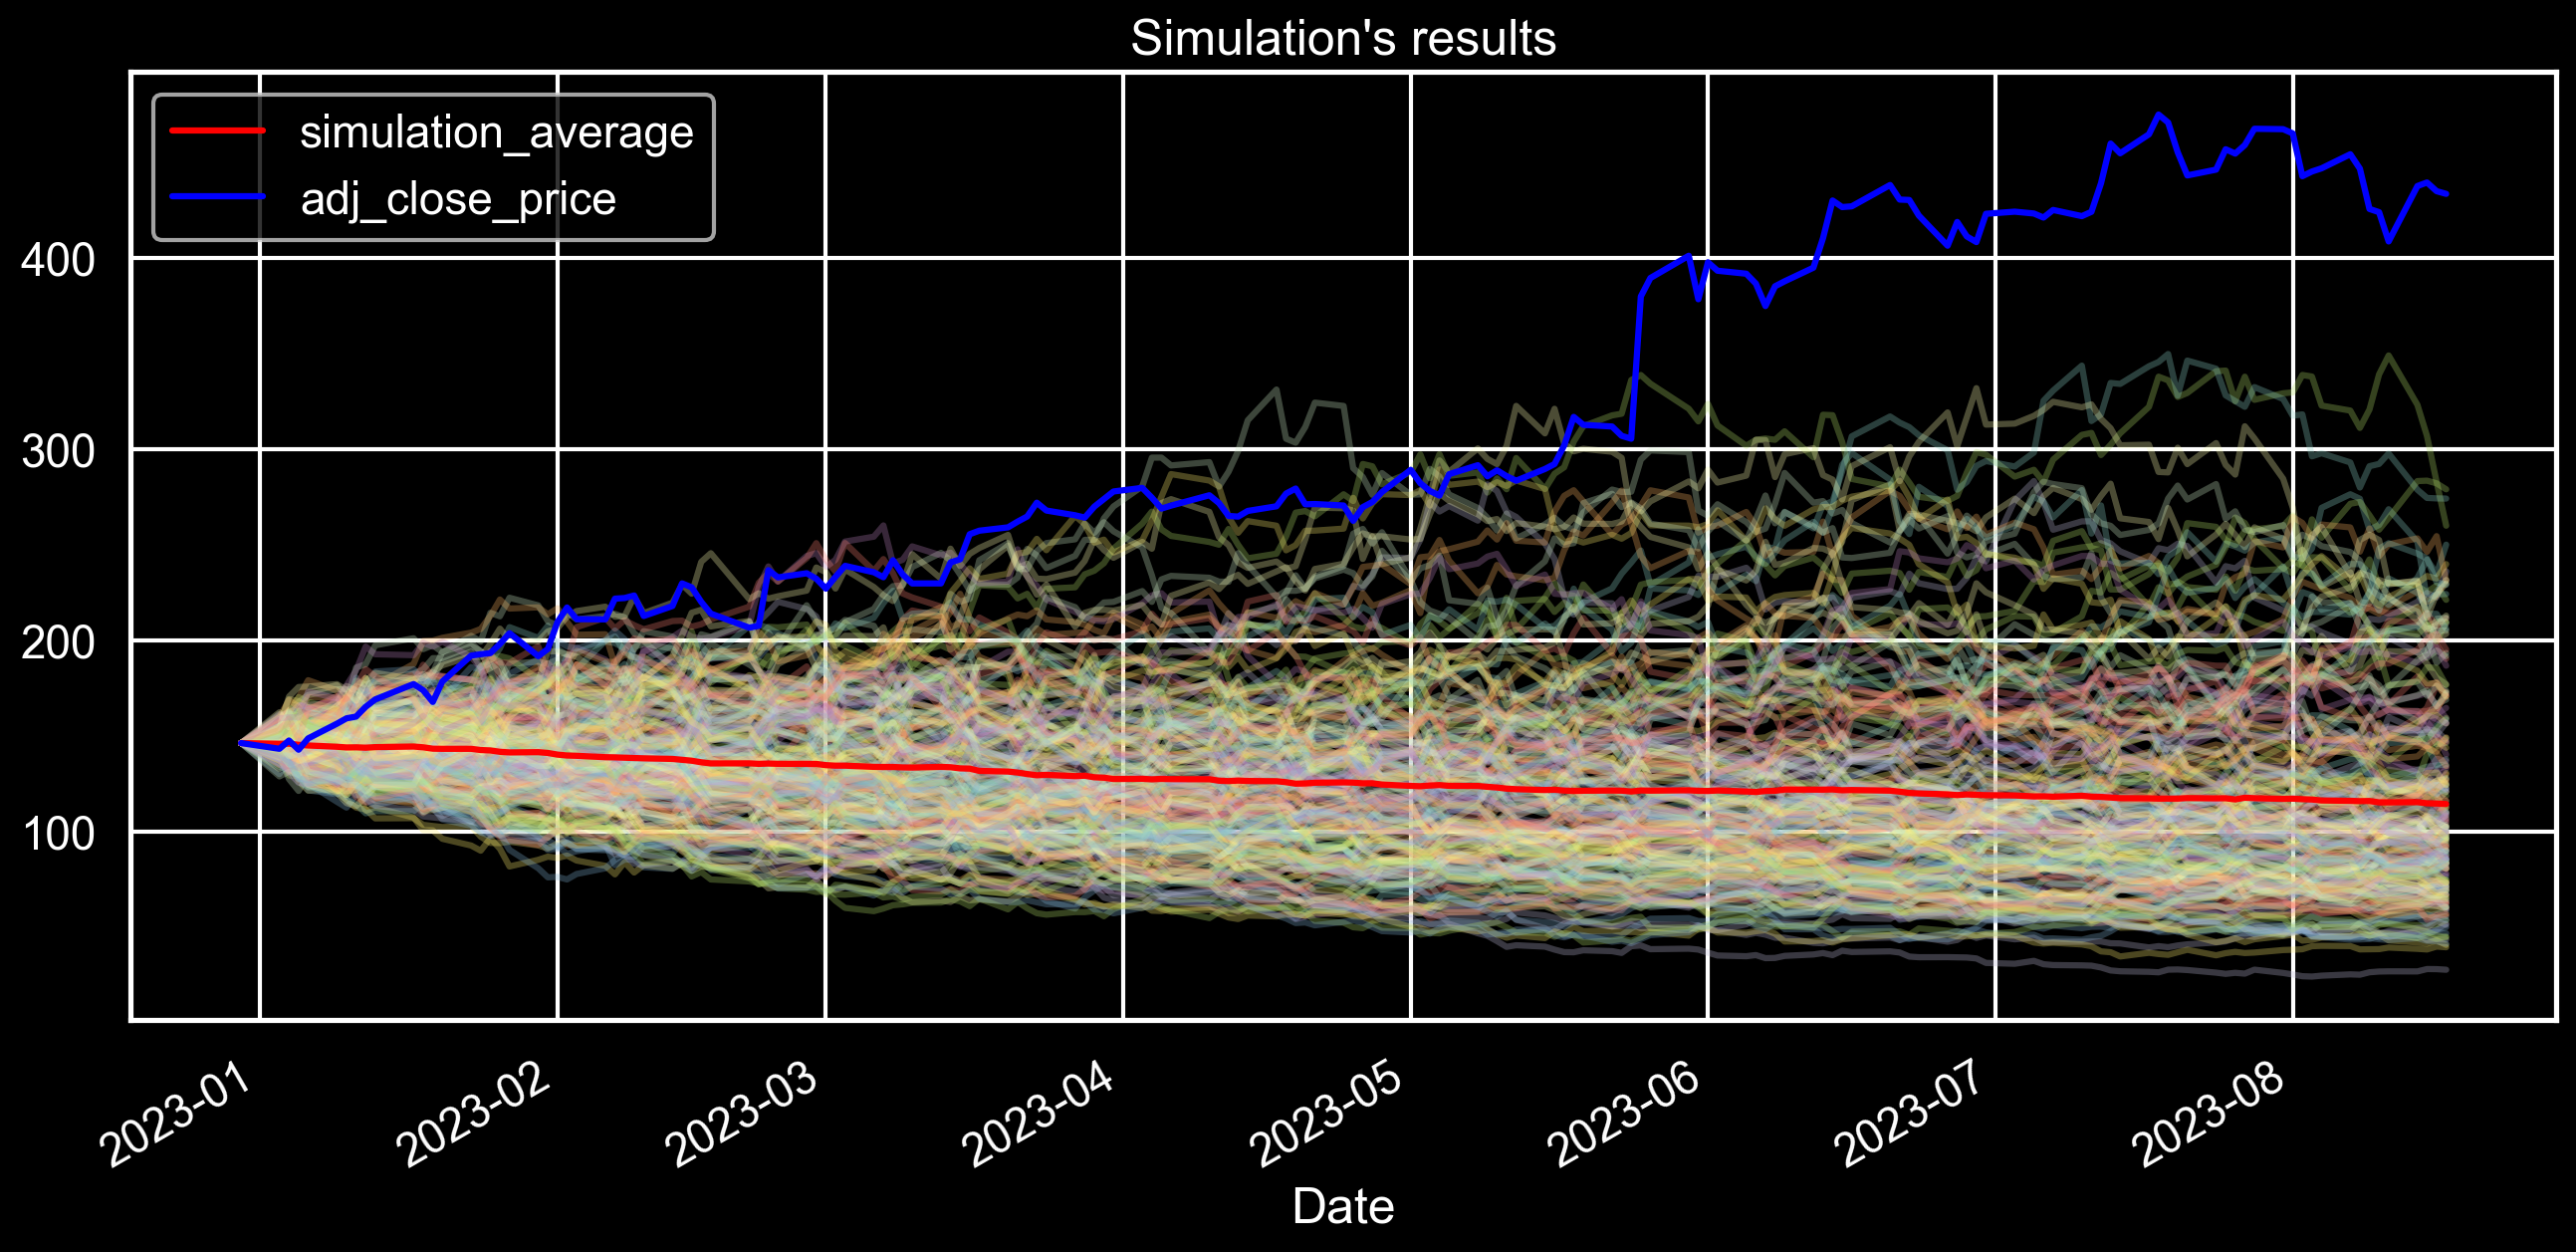

In [393]:
ax = sim_df.plot(
alpha=0.3, legend=False, title="Simulation's results")
res_df.plot(ax=ax, color = ["red", "blue"])

In [394]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

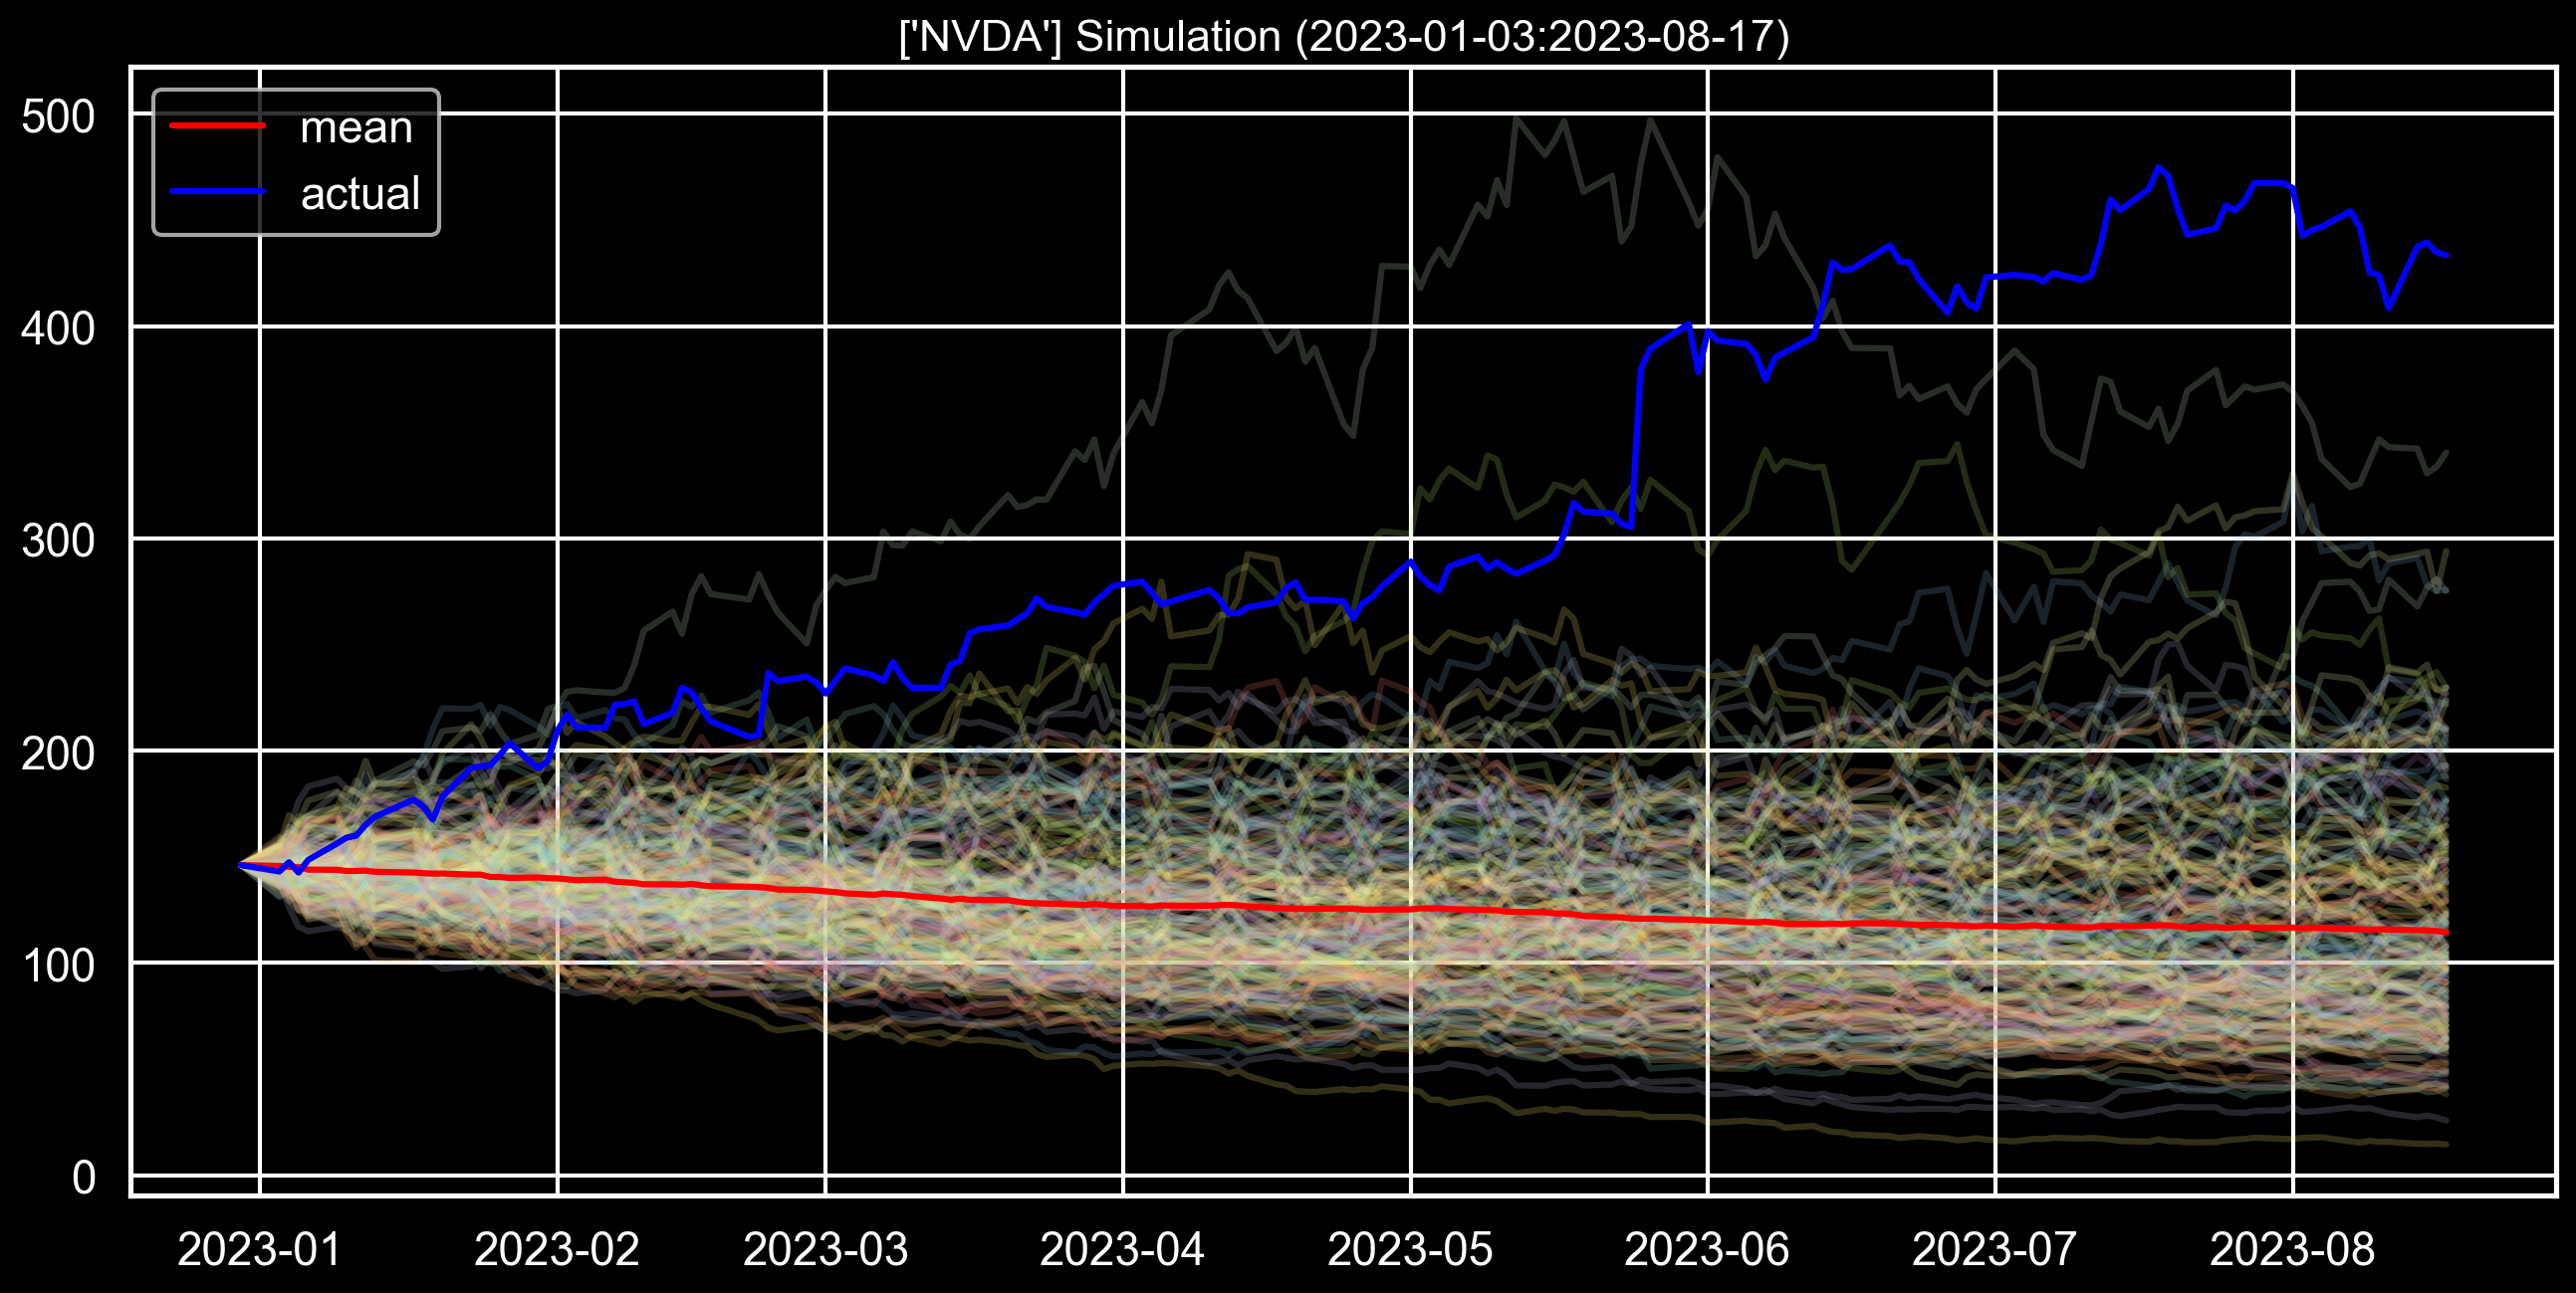

In [395]:
# prepare objects for plotting
LAST_TRAIN_DATE = train.index[-1].date()
FIRST_TEST_DATE = test.index[0].date()
LAST_TEST_DATE = test.index[-1].date()
PLOT_TITLE = (f'{ticker} Simulation '
f'({FIRST_TEST_DATE}:{LAST_TEST_DATE})')
selected_indices = adj_close[LAST_TRAIN_DATE:LAST_TEST_DATE].index
index = [date.date() for date in selected_indices]
gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations),
index=index)
# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1),
color='red')
line_2, = ax.plot(index, adj_close[LAST_TRAIN_DATE:LAST_TEST_DATE],
color='blue')
ax.set_title(PLOT_TITLE, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))